In [4]:
# where is it ?

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [5]:
train_df_full = pd.read_csv('train.csv')#'/kaggle/input/playground-series-s4e9/train.csv')
test_df_full = pd.read_csv('test.csv')#'/kaggle/input/playground-series-s4e9/test.csv')


Evaluating models for dev_fraction: 0.02, Data shape: (3771, 13)
CatBoost (Balanced): CV RMSE score: 64210.36777 ± 35145.34105
CatBoost (Aggressive Learning): CV RMSE score: 64283.66424 ± 35723.41919
CatBoost (Shallow but Fast): CV RMSE score: 65689.41780 ± 37035.33188
Ridge (Mild Regularization): CV RMSE score: 58423.93930 ± 36128.00245
Ridge (Low Regularization): CV RMSE score: 58424.11041 ± 36127.99646
Ridge (High Regularization): CV RMSE score: 58422.25786 ± 36128.05726

Evaluating models for dev_fraction: 0.05, Data shape: (9427, 13)
CatBoost (Balanced): CV RMSE score: 65684.87547 ± 31667.34439
CatBoost (Aggressive Learning): CV RMSE score: 65343.83530 ± 31633.22140
CatBoost (Shallow but Fast): CV RMSE score: 66128.57955 ± 31489.09393
Ridge (Mild Regularization): CV RMSE score: 64564.50064 ± 32248.63336
Ridge (Low Regularization): CV RMSE score: 64564.61971 ± 32248.64451
Ridge (High Regularization): CV RMSE score: 64563.31591 ± 32248.52250

Evaluating models for dev_fraction: 0.1

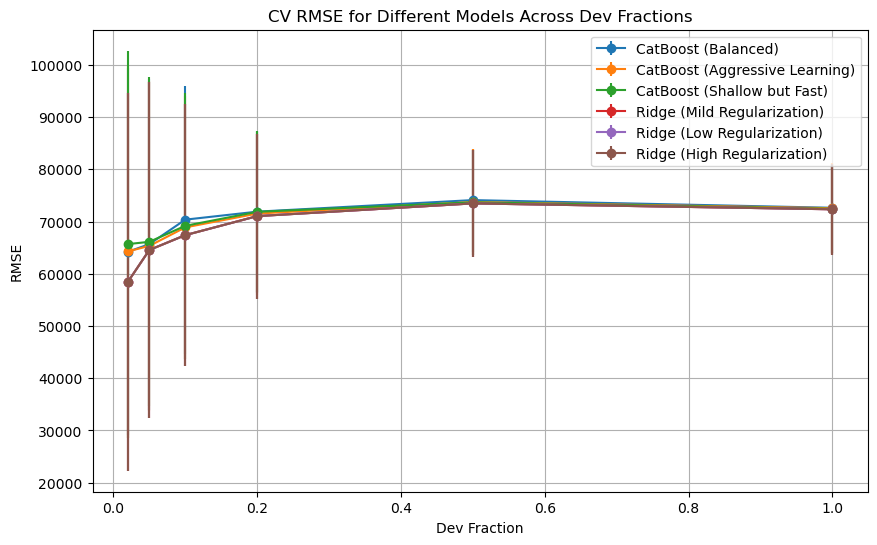

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor



# Set up parameters for cross-validation
SEED = 3
num_splits = 10
n_repeats = 3
kfold = RepeatedKFold(n_splits=num_splits, n_repeats=n_repeats, random_state=SEED)
scoring = 'neg_root_mean_squared_error'



# Define a function to perform cross-validation
def cross_val_evaluate_model(X, y, model, kfold, scoring='neg_root_mean_squared_error'):
    pipeline = make_pipeline(
        TargetEncoder(random_state=SEED, target_type='continuous').set_output(transform='pandas'),
        StandardScaler().set_output(transform='pandas'),
        model
    )
    
    scores = -cross_val_score(pipeline, X, y, scoring=scoring, cv=kfold, n_jobs=-1)
    return np.mean(scores), np.std(scores)

# Define different dev fractions to evaluate
dev_fractions = [0.02, 0.05, 0.1, .2, .5, 1]

# Define different models
models = {
    'Random Forest': RandomForestRegressor(random_state=SEED),
    'CatBoost': CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_state=SEED, silent=True),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8, random_state=SEED),
    'Ridge Regression': Ridge(alpha=1.0)
}

models = {
    # CatBoost Setups
    'CatBoost (Balanced)': CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, l2_leaf_reg=3, random_state=SEED, silent=True),
    'CatBoost (Aggressive Learning)': CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, l2_leaf_reg=5, random_state=SEED, silent=True),
    'CatBoost (Shallow but Fast)': CatBoostRegressor(iterations=300, depth=4, learning_rate=0.1, l2_leaf_reg=2, random_state=SEED, silent=True),

    # Ridge Regression Setups
    'Ridge (Mild Regularization)': Ridge(alpha=1.0),
    'Ridge (Low Regularization)': Ridge(alpha=0.1),
    'Ridge (High Regularization)': Ridge(alpha=10.0)
}
# Store the results for plotting
results = []

# Loop over dev fractions and models
for dev_frac in dev_fractions:
    df_dev = train_df_full.sample(frac=dev_frac, random_state=SEED)

    # Separate features (X) and target (y)
    X = df_dev.drop(columns='price')
    y = df_dev['price']

    # Feature engineering: bin mileage
    if 'milage' in X.columns:
        X['mileage'] = X.pop('milage') // 100

    print(f'\nEvaluating models for dev_fraction: {dev_frac}, Data shape: {df_dev.shape}')

    # Loop over each model
    for model_name, model in models.items():
        mean_score, std_score = cross_val_evaluate_model(X, y, model, kfold, scoring=scoring)
        print(f'{model_name}: CV RMSE score: {mean_score:.5f} ± {std_score:.5f}')
        
        # Store results
        results.append({
            'model': model_name,
            'dev_fraction': dev_frac,
            'mean_rmse': mean_score,
            'std_rmse': std_score
        })

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot RMSE mean and standard deviation for each model and dev_fraction
for model_name in models.keys():
    model_results = results_df[results_df['model'] == model_name]
    plt.errorbar(model_results['dev_fraction'], model_results['mean_rmse'], 
                 yerr=model_results['std_rmse'], label=model_name, fmt='-o')

plt.title('CV RMSE for Different Models Across Dev Fractions')
plt.xlabel('Dev Fraction')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


# producing the submission file

In [12]:
model = make_pipeline(
    TargetEncoder(random_state=0, target_type='continuous').set_output(transform='pandas'),
    StandardScaler().set_output(transform='pandas'),
    Ridge(alpha=10.0)
)


# Step 2: Separate features (X) and target (y) from the full training set
X_train = train_df_full.drop(columns='price')
y_train = train_df_full['price']


# Step 3: Fit the model on the full training data
model.fit(X_train, y_train)

# Step 4: Prepare test data and make predictions
X_test = test_df_full#.drop(columns='id')  # Assuming 'id' column is in test data
predictions = model.predict(X_test)

# Step 5: Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_df_full['id'],  # Ensure the 'id' from the test set is preserved
    'price': predictions       # The predicted prices
})

# Step 6: Save the submission to a CSV file
submission.to_csv('submission3_TargetRidge10ScalePipeline.csv', index=False)  # Save as CSV

In [19]:

from sklearn.preprocessing import TargetEncoder, StandardScaler

# Assuming X_train and y_train are your feature matrix and target
te = TargetEncoder(random_state=0, target_type='continuous').set_output(transform='pandas')
scaler = StandardScaler().set_output(transform='pandas')
ridge = Ridge(alpha=10.0)

# Step 1: Fit the TargetEncoder and transform X_train
X_train_encoded = te.fit_transform(X_train, y_train)
print(f"Shape after TargetEncoder: {X_train_encoded.shape}")

# Step 2: Fit the StandardScaler and transform the encoded X_train
X_train_scaled = scaler.fit_transform(X_train_encoded)
print(f"Shape after StandardScaler: {X_train_scaled.shape}")

# Step 3: Now fit the Ridge model
ridge.fit(X_train_scaled, y_train)
print(f"Shape of target (y_train): {y_train.shape}")


Shape after TargetEncoder: (188533, 12)
Shape after StandardScaler: (188533, 12)
Shape of target (y_train): (188533,)


In [22]:
# Step 4: Access the coefficients and intercept
ridge_coefficients = ridge.coef_  # Feature coefficients
ridge_intercept = ridge.intercept_  # Bias term (intercept)

# Print results
print("Ridge Coefficients:")
print(ridge_coefficients)

print("Ridge Intercept (Bias):")
print(ridge_intercept)

Ridge Coefficients:
[ -468.7448107   2845.18278775  3019.08148566  3834.90680762
 14246.62129684 -1472.70495516 10475.08769075   481.49783869
  2770.75566342   904.04637975   959.08921553 -2223.56282994]
Ridge Intercept (Bias):
43878.016177292084


In [21]:
X_train.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')

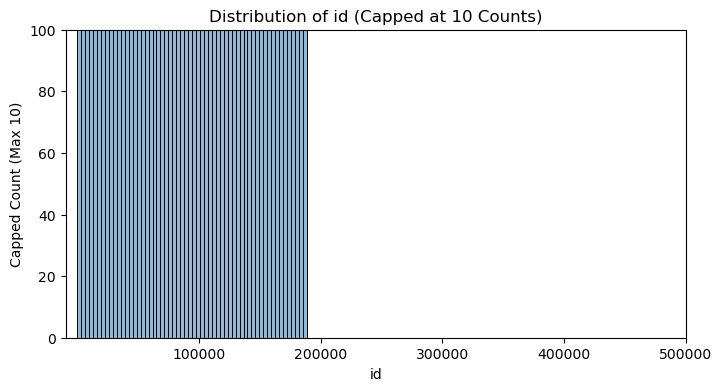

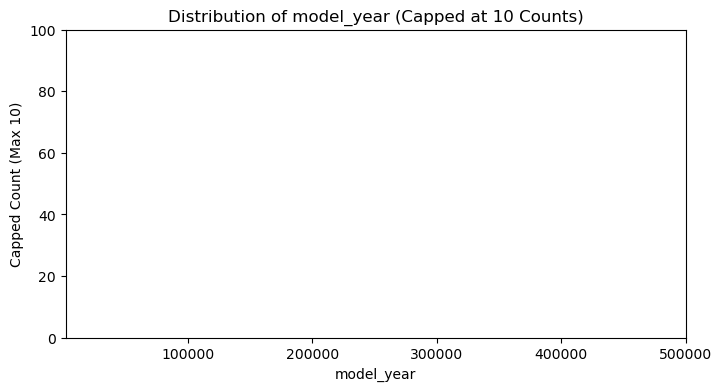

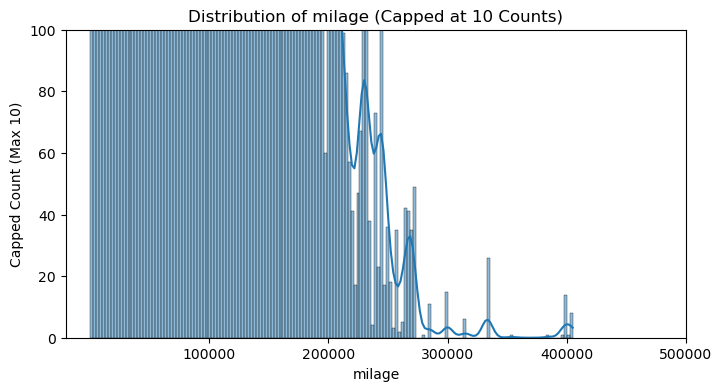

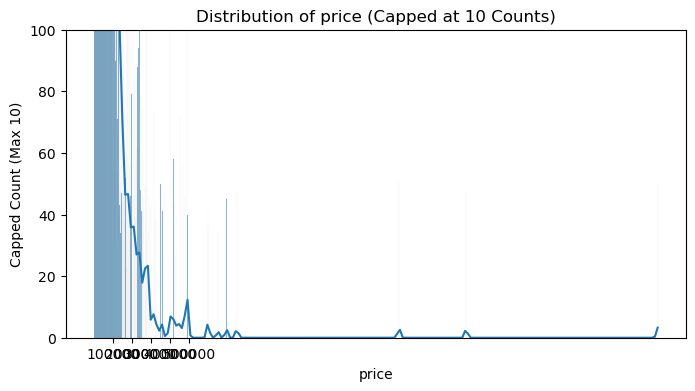

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions_with_cap(df, N=10):
    # Separate numerical columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Plot for numerical columns with count capping
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        
        # Plot the histogram with KDE
        sns.histplot(df[col], kde=True)
        
        # Cap the counts at 10 by setting the y-limit
        plt.ylim(0, 100)
        
        plt.title(f'Distribution of {col} (Capped at 10 Counts)')
        plt.xlabel(col)
        plt.ylabel('Capped Count (Max 10)')
        plt.xticks([x * 10**6 for x in [.1, .2, .3, .4, .5]])
        plt.show()


plot_distributions_with_cap(train_df_full, N=10)

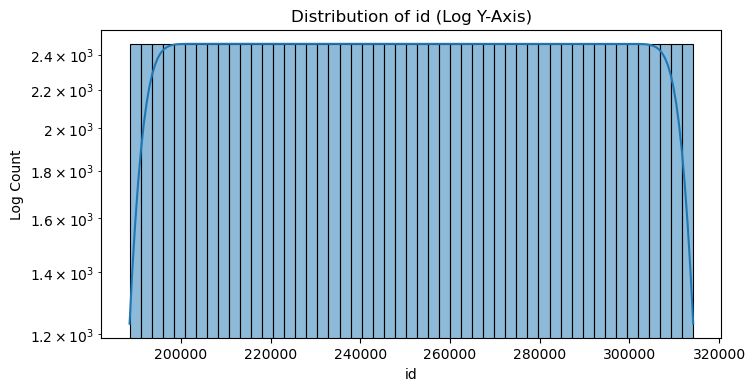

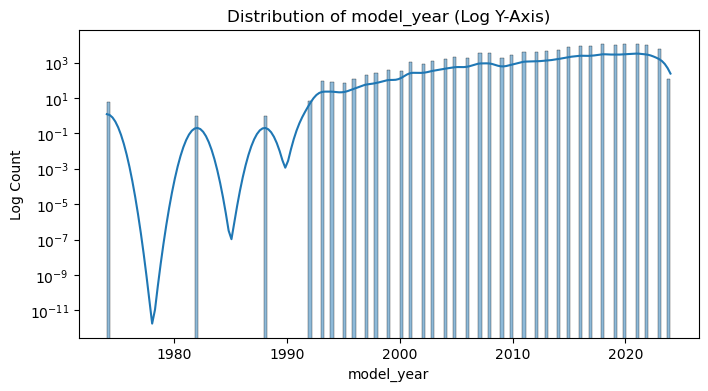

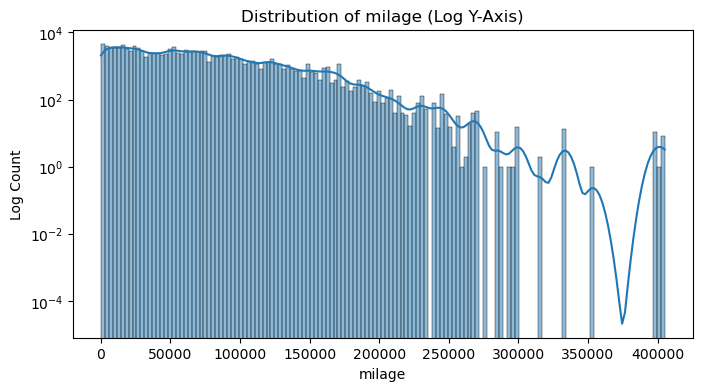

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions_log_yaxis(df, N=10):
    # Separate numerical columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Plot for numerical columns with a log scale on the y-axis
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        
        # Plot the histogram with KDE
        sns.histplot(df[col], kde=True)
        
        # Set y-axis to log scale
        plt.yscale('log')
        
        plt.title(f'Distribution of {col} (Log Y-Axis)')
        plt.xlabel(col)
        plt.ylabel('Log Count')
        plt.show()

plot_distributions_log_yaxis(test_df_full, N=10)
